# Martin Iniguez de Onzono Muruaga. Sheet 09

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import svm
import libsvm
from sklearn.model_selection import KFold

## Exercise 2. C-SVM with standard parameters.

### 1. Construct your data.

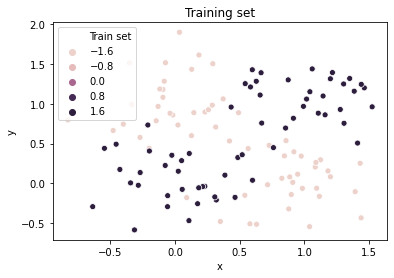

In [3]:
mu_1 = np.array([0,1]).T
mu_2 = np.array([1,0]).T
mu_3 = np.array([0,0]).T
mu_4 = np.array([1,1]).T
var = 0.1
num = 60

n_1=np.random.multivariate_normal(mu_1,np.identity(2)*var,2*num)
n_2=np.random.multivariate_normal(mu_2,np.identity(2)*var,2*num)
n_3=np.random.multivariate_normal(mu_3,np.identity(2)*var,2*num)
n_4=np.random.multivariate_normal(mu_4,np.identity(2)*var,2*num)

train_data = np.zeros((num*2,2))
labels_train = np.zeros(num*2)

test_data = np.zeros((num*2,2))

for i in range(0,num):
    labels_train[i]=-1
    labels_train[i+num]=1
    
    if i%2==0:
        
        test_data[i,:] = n_1[i+num,:]
        test_data[i+num,:] = n_3[i+num,:]
        
        train_data[i,:] = n_1[i,:]
        train_data[i+num,:] = n_3[i,:]
    else:
        
        test_data[i,:] = n_2[i+num,:]
        test_data[i+num,:] = n_4[i+num,:]
        
        train_data[i,:] = n_2[i,:]
        train_data[i+num,:] = n_4[i,:]

labels_test = labels_train
        
x = train_data[:,0]
y = train_data[:,1]

train_set = {'x': x,'y': y,'Train set': labels_train}
train_set = pd.DataFrame(train_set, columns = ['x', 'y','Train set'])

sn.scatterplot(data=train_set,x='x',y='y',hue='Train set'); 
plt.title('Training set');

### 2 & 3. Software and training of the first classifier.

The accuracy of the model is 87.5%


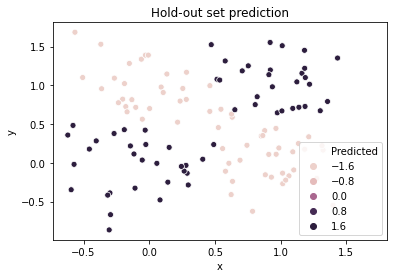

In [4]:
rbf_svc = svm.SVC(kernel='rbf',probability=False)
rbf_svc.fit(train_data,labels_train)
test_predict = rbf_svc.predict(test_data)

# Putting the test set into a data frame

x = test_data[:,0]
y = test_data[:,1]
test_set = {'x': x,'y': y,'Predicted': test_predict}
test_set = pd.DataFrame(test_set, columns = ['x', 'y','Predicted'])

acc1=round(rbf_svc.score(test_data,labels_test)*100,2)

sn.scatterplot(data=test_set,x='x',y='y',hue='Predicted'); 
print('The accuracy of the model is '+str(acc1) + '%')
plt.title('Hold-out set prediction');

In [5]:
def svc_grid(svm_model,num_points):
    
    # Passing a SVC classifier (svm_model) over a meshgrid of num_points^2
    
    x=np.linspace(-1,2,num_points)
    y=np.linspace(-1,2,num_points)
    xx, yy= np.array(np.meshgrid(x,y))

    points_grid=np.c_[xx.ravel(),yy.ravel()]
    labels = np.zeros(len(points_grid))

    labels = svm_model.predict(points_grid)
    

    return points_grid,labels 

Text(0.5, 1.0, 'Countour lines with default parameters.')

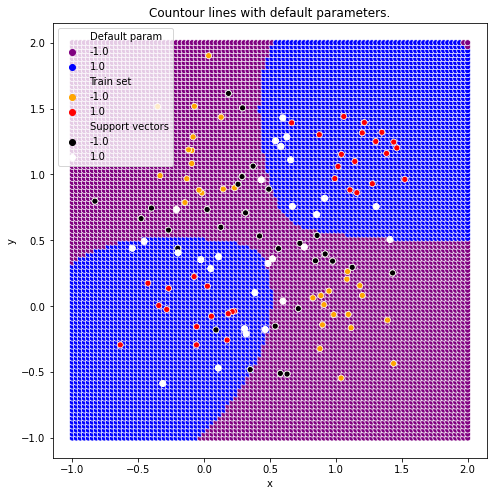

In [6]:
# Finding the support vectors of the model

supp_vectors1 = rbf_svc.support_vectors_
ind_supp1 = labels_train[rbf_svc.support_]
num_supp1 = len(rbf_svc.support_)

x = supp_vectors1[:,0]
y = supp_vectors1[:,1]
supp_vec1 = {'x': x,'y': y,'Support vectors': ind_supp1}
supp_set1 = pd.DataFrame(supp_vec1, columns = ['x', 'y','Support vectors'])

# Creating the contour lines for this model

points_grid,labels_grid = svc_grid(rbf_svc,100)

x=points_grid[:,0]
y=points_grid[:,1]
countour_set = {'x': x,'y': y,'Default param': labels_grid}
countour_grid= pd.DataFrame(countour_set,columns={'x','y','Default param'})

# Plotting

fig,ax = plt.subplots(figsize=(8,8))

sn.scatterplot(data=countour_grid,x='x',y='y',hue='Default param',palette=['purple','blue']); 
sn.scatterplot(data=train_set,x='x',y='y',hue='Train set',palette=['orange','red']);
sn.scatterplot(data=supp_set1,x='x',y='y',hue='Support vectors',palette=['black','white']);
ax.set_aspect('equal', adjustable='box');
ax.set_title('Countour lines with default parameters.')

## Exercise 3. C-SVM parameter optimization

### a) Use cross-validation and grid-search to determine good values for the C and the kernel parameter gamma.

In [7]:
# Performing cross-validation algorithm for all C's and gammas 

kfold= KFold(10, shuffle=True, random_state=1)

C=np.float(2)**(np.linspace(-6,10.0001,40))
gamma=np.float(2)**(np.linspace(-5,9.0001,40))

mean_acc_train = np.zeros((len(C),len(gamma)))
mean_acc_test = np.zeros((len(C),len(gamma)))
                          
for i,C_exp in enumerate(C):
    
    for j,gamma_exp in enumerate(gamma):
        
        acc_train = np.zeros(10)
        acc_test = np.zeros(10)
        num = 0

        for train, test in kfold.split(train_data):

            rbf_svc = svm.SVC(kernel='rbf',probability=False,C=C_exp,gamma=gamma_exp)
            rbf_svc.fit(train_data[train],labels_train[train])
            acc_train[num] = rbf_svc.score(train_data,labels_train)*100
            acc_test[num] = rbf_svc.score(test_data,labels_test)*100
            num += 1

        mean_acc_train[i][j] = np.mean(acc_train)
        mean_acc_test[i][j] = np.mean(acc_test) 

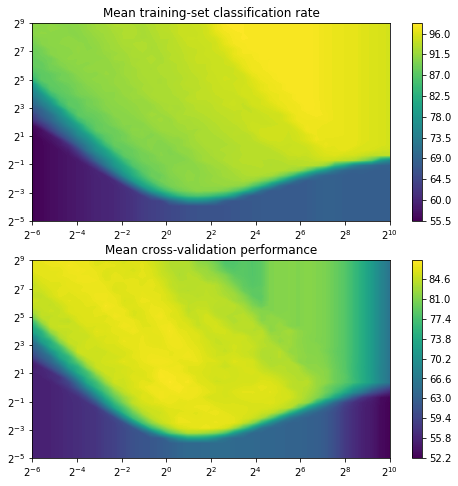

In [13]:
# Creating the countour plots

fig, ax = plt.subplots(figsize=(8,8),nrows=2)

c1=ax[0].contourf(C,gamma,mean_acc_train, levels=200)
ax[0].set_xscale('log', basex=2)
ax[0].set_yscale('log', basey=2)
ax[0].set_title('Mean training-set classification rate');
fig.colorbar(c1, ax=ax[0]);

c2=ax[1].contourf(C,gamma,mean_acc_test, levels=200)
ax[1].set_xscale('log', basex=2)
ax[1].set_yscale('log', basey=2)
ax[1].set_title('Mean cross-validation performance');
fig.colorbar(c2, ax=ax[1]);

### b & c) Find the combination of C and gamma yielding the best validation-performance. Compare the results to H9.2 and see what happens when diving your best parameters.

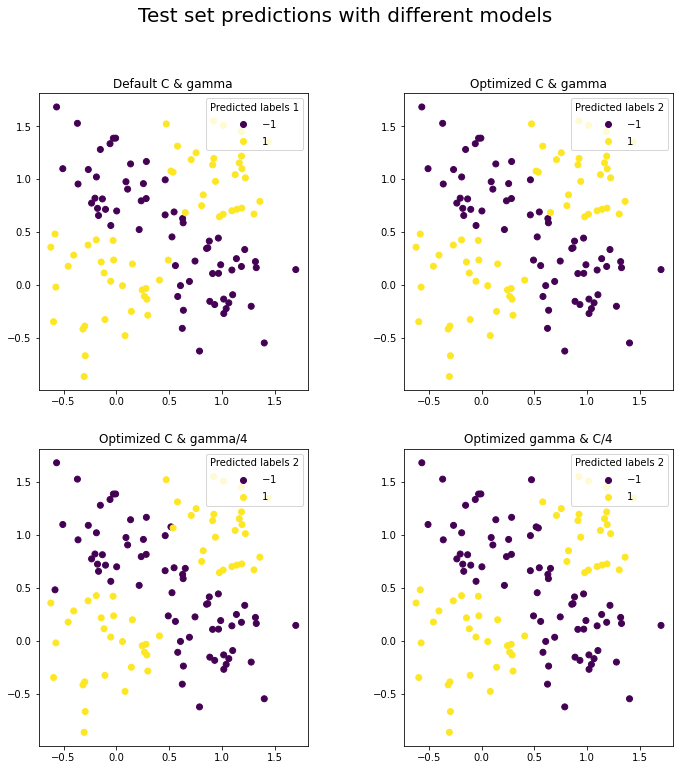

In [9]:
# Finding the best C and gamma

ind = np.argmax(mean_acc_test)
row_ind , col_ind = np.unravel_index(ind,mean_acc_test.shape)

#Fitting the model 

svc_2 = svm.SVC(C=C[row_ind],gamma=gamma[col_ind])
svc_2.fit(train_data,labels_train);

test_predict2 = svc_2.predict(test_data)
acc2=round(svc_2.score(test_data,labels_test)*100,2)

num_supp2 = len(svc_2.support_)
supp_vectors2 = svc_2.support_vectors_
ind_supp2 = labels_train[svc_2.support_]

# Fitting the model with divided gamma

svc_3 = svm.SVC(C=C[row_ind],gamma=gamma[col_ind]/4)
svc_3.fit(train_data,labels_train);

test_predict3 = svc_3.predict(test_data)
acc3=round(svc_3.score(test_data,labels_test)*100,2)

num_supp3 = len(svc_3.support_)
supp_vectors3 = svc_3.support_vectors_
ind_supp3 = labels_train[svc_3.support_]

# Fitting the model with divided C 

svc_4 = svm.SVC(C=C[row_ind]/4,gamma=gamma[col_ind])
svc_4.fit(train_data,labels_train);

test_predict4 = svc_4.predict(test_data)
acc4=round(svc_4.score(test_data,labels_test)*100,2)

supp_vectors4 = svc_4.support_vectors_
num_supp4 = len(svc_4.support_)
ind_supp4 = labels_train[svc_4.support_]

# Plotting

fig, ax = plt.subplots(figsize=(12,12),nrows=2,ncols=2)

fig.suptitle('Test set predictions with different models',fontsize=20)

scat = ax[0][0].scatter(test_data[:,0], test_data[:,1], c=test_predict,label=test_predict)
ax[0][0].set_aspect('equal', adjustable='box');
ax[0][0].legend(*scat.legend_elements(), loc="upper right", title="Predicted labels 1")
ax[0][0].set_title('Default C & gamma')

scat = ax[0][1].scatter(test_data[:,0], test_data[:,1], c=test_predict2,label=test_predict2)
ax[0][1].set_aspect('equal', adjustable='box');
ax[0][1].legend(*scat.legend_elements(), loc="upper right", title="Predicted labels 2")
ax[0][1].set_title('Optimized C & gamma');

scat = ax[1][0].scatter(test_data[:,0], test_data[:,1], c=test_predict3,label=test_predict3)
ax[1][0].set_aspect('equal', adjustable='box');
ax[1][0].legend(*scat.legend_elements(), loc="upper right", title="Predicted labels 2")
ax[1][0].set_title('Optimized C & gamma/4');

scat = ax[1][1].scatter(test_data[:,0], test_data[:,1], c=test_predict4,label=test_predict4)
ax[1][1].set_aspect('equal', adjustable='box');
ax[1][1].legend(*scat.legend_elements(), loc="upper right", title="Predicted labels 2")
ax[1][1].set_title('Optimized gamma & C/4');

fig.tight_layout;

In [10]:
print('Accuracies of the models:\n'+
      'Default model: '+str(acc1) + '%\n'+
      'Optimized model: '+str(acc2) + '%\n'+
      'Optimized C, gamma/4: '+str(acc3) + '%\n'+
      'Optimized gamma, C/4: '+str(acc4) + '%\n')

print('Number of support vectors:\n'+
      'Default model: '+str(num_supp1) + '\n'+
      'Optimized model: '+str(num_supp2) + '\n'+
      'Optimized C, gamma/4: '+str(num_supp3) + '\n'+
      'Optimized gamma, C/4: '+str(num_supp4))

Accuracies of the models:
Default model: 87.5%
Optimized model: 86.67%
Optimized C, gamma/4: 85.83%
Optimized gamma, C/4: 85.0%

Number of support vectors:
Default model: 57
Optimized model: 57
Optimized C, gamma/4: 86
Optimized gamma, C/4: 84


In [11]:
# Building the support vectors Data Frames for all models

x = supp_vectors2[:,0]
y = supp_vectors2[:,1]
supp_vec2 = {'x': x,'y': y,'Support vectors': ind_supp2}
supp_set2 = pd.DataFrame(supp_vec2, columns = ['x', 'y','Support vectors'])

x = supp_vectors3[:,0]
y = supp_vectors3[:,1]
supp_vec3 = {'x': x,'y': y,'Support vectors': ind_supp3}
supp_set3 = pd.DataFrame(supp_vec3, columns = ['x', 'y','Support vectors'])

x = supp_vectors4[:,0]
y = supp_vectors4[:,1]
supp_vec4 = {'x': x,'y': y,'Support vectors': ind_supp4}
supp_set4 = pd.DataFrame(supp_vec4, columns = ['x', 'y','Support vectors'])

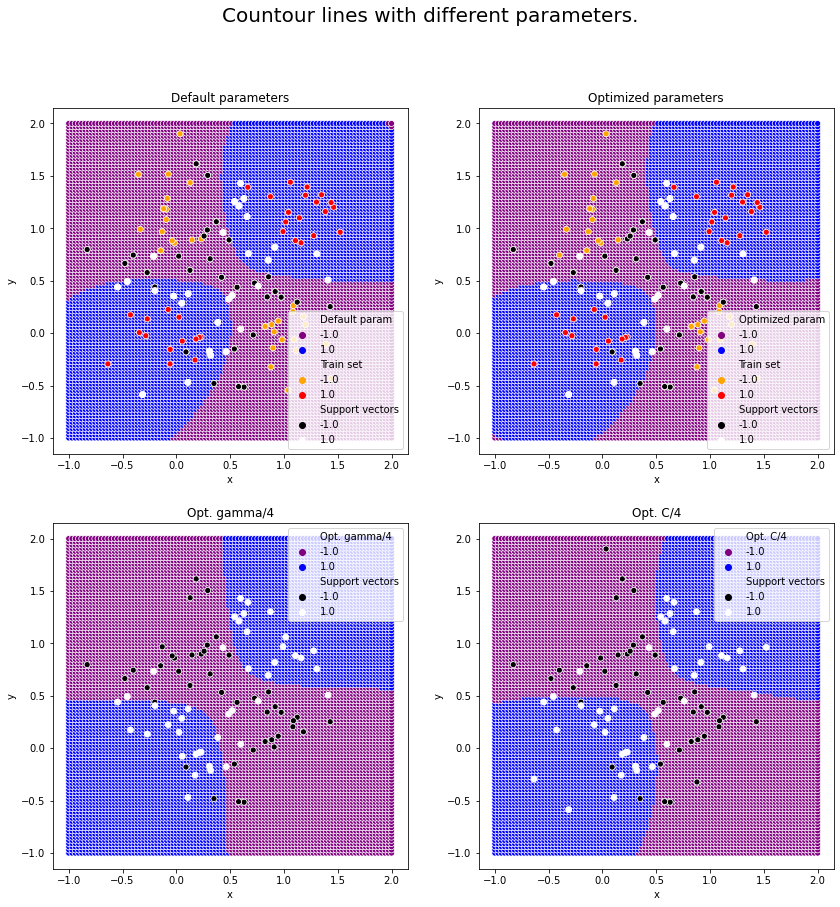

In [12]:
# Finding the countour lines for all models

points_grid,labels_grid2 = svc_grid(svc_2,100)
points_grid,labels_grid3 = svc_grid(svc_3,100)
points_grid,labels_grid4 = svc_grid(svc_4,100)

countour_grid['Optimized param']=labels_grid2
countour_grid['Opt. gamma/4']=labels_grid3
countour_grid['Opt. C/4']=labels_grid4

# Plotting

fig = plt.figure(figsize=(14,14))

fig.suptitle('Countour lines with different parameters.',fontsize=20)

fig.add_subplot(2, 2, 1)

plt.title('Default parameters')
sn.scatterplot(data=countour_grid,x='x',y='y',hue='Default param',palette=['purple','blue']); 
sn.scatterplot(data=train_set,x='x',y='y',hue='Train set',palette=['orange','red']);
sn.scatterplot(data=supp_set1,x='x',y='y',hue='Support vectors',palette=['black','white']);

fig.add_subplot(2, 2, 2)

plt.title('Optimized parameters')
sn.scatterplot(data=countour_grid,x='x',y='y',hue='Optimized param',palette=['purple','blue']); 
sn.scatterplot(data=train_set,x='x',y='y',hue='Train set',palette=['orange','red']);
sn.scatterplot(data=supp_set2,x='x',y='y',hue='Support vectors',palette=['black','white']);

fig.add_subplot(2, 2, 3)

plt.title('Opt. gamma/4')
sn.scatterplot(data=countour_grid,x='x',y='y',hue='Opt. gamma/4',palette=['purple','blue']); 
sn.scatterplot(data=supp_set3,x='x',y='y',hue='Support vectors',palette=['black','white']);

fig.add_subplot(2, 2, 4)

plt.title('Opt. C/4')
sn.scatterplot(data=countour_grid,x='x',y='y',hue='Opt. C/4',palette=['purple','blue']);
sn.scatterplot(data=supp_set4,x='x',y='y',hue='Support vectors',palette=['black','white']);

It can be seen that, taking the optimal parameters and diving them by 4, we turn all vectors into support vectors.